## Get ENCODE metadata of all experiments, files, biosamples
Load/download ENCODE reports and metadata. We can go with report.tsv or /metadata/. 

However, report.tsv returns a lot more entries. Did not look into the differences (should be the same after filtering).

Query again to obtain extra fields for each file (dbxrefs and biosample)

Merge report_file, report_file_extra, and report_sam (report_expt is not used for now)

### ToDo
1. Consider to remove some unused columns in the output

In [21]:
import io
import requests
import importlib
import pandas as pd
from pathlib import Path
from collections import Counter
import brew_omics
importlib.reload(brew_omics)

# limit=all gives you the default "report" columns.
# One can get similar output by visiting the URL below in a web browser (adding &format=text to get TSV):
#  https://www.encodeproject.org/search/?type=Experiment&status=released

init_files, init_files_path = brew_omics.fetch_encode_metadata(
    "data/encode/init_files.pkl",
    "https://www.encodeproject.org/report.tsv?type=File&limit=all", 
    check_ids=['ID', 'Dataset'], skip_rows=1, sep='\t', data_type='File')

init_samples, init_samples_path = brew_omics.fetch_encode_metadata(
    "data/encode/init_samples.pkl",
    "https://www.encodeproject.org/report.tsv?type=Biosample&limit=all", 
    check_ids=['ID'], skip_rows=1, sep='\t', data_type='Biosample')

init_experiments, init_experiments_path = brew_omics.fetch_encode_metadata(
    "data/encode/init_experiments.pkl",
    "https://www.encodeproject.org/report.tsv?type=Experiment&limit=all", 
    check_ids=['ID'], skip_rows=1, sep='\t', data_type='Experiment')

# The return only has two columns: ID and Aliases (not useful)
# report_replicate, report_replicate_path = brew_omics.fetch_encode_metadata(
#     "data/encode/report_replicate.pkl",
#     "https://www.encodeproject.org/report.tsv?type=Replicate&limit=all&field=", 
#     check_ids=['ID', 'Dataset'], skip_rows=1, sep='\t', data_type='Replicate', overwrite=True)

# metadata query appears to always return one row per file, even though type=Experiment or type=Biosample is specified
# metadata_file, metadata_file_path = fetch_encode_metadata(
#     "data/encode/metadata_file.pkl",
#     "https://www.encodeproject.org/metadata/?type=File&limit=all", 
#     # url = "https://www.encodeproject.org/metadata/?type=Experiment&field=replicate.library.biosample.accession&field=replicate.library.biosample.dbxrefs"    
#     # url = "https://www.encodeproject.org/metadata/?type=Experiment&limit=all"
#     check_ids=['ID', 'Dataset'],
#     data_type='File')

Searching ENCODE: https://www.encodeproject.org/report.tsv?type=File&limit=all
Response size: 777536987 bytes, Lines: 1560651


/home/xqiu/codedev/pylib/brew_omics.py:47: DtypeWarning:

Columns (21,33,40,41,44,45,46) have mixed types. Specify dtype option on import or set low_memory=False.



Response loaded into DataFrame with shape: (1560649, 47)
Saved ENCODE data to data/encode/init_files.pkl
    column 'ID': files = 1560649
    column 'Dataset': experiments = 860297
    column 'Dataset': annotations = 672401
    column 'Dataset': functional-characterization-experiments = 10533
    column 'Dataset': single-cell-units = 8288
    column 'Dataset': references = 5942
    column 'Dataset': reference-epigenomes = 2157
    column 'Dataset': aggregate-series = 688
    column 'Dataset': functional-characterization-series = 211
    column 'Dataset': ucsc-browser-composites = 100
    column 'Dataset': replication-timing-series = 14
    column 'Dataset': matched-sets = 10
    column 'Dataset': projects = 4
    column 'Dataset': multiomics-series = 3
    column 'Dataset': treatment-time-series = 1
Searching ENCODE: https://www.encodeproject.org/report.tsv?type=Biosample&limit=all
Response size: 10114156 bytes, Lines: 29936
Response loaded into DataFrame with shape: (29934, 29)
Saved 

/home/xqiu/codedev/pylib/brew_omics.py:47: DtypeWarning:

Columns (36) have mixed types. Specify dtype option on import or set low_memory=False.



Response loaded into DataFrame with shape: (27398, 40)
Saved ENCODE data to data/encode/init_experiments.pkl
    column 'ID': experiments = 27398


In [22]:
# Search Encode again to get dbxrefs and biosample id and for each file
init_files_extra_path = Path("data/encode/init_files_extra.pkl")
fields_list = [
    "accession",
    "assay_title",
    # "file_format",
    # "file_type",
    "dbxrefs",
    # "replicate.library.accession",
    "replicate.library.biosample",
    "replicate.library.dbxrefs",
    "donors",
    # "output_type",
    # "derived_from",
    "cloud_metadata.url",
    "cloud_metadata.md5sum_base64",
    "cloud_metadata.file_size",
    "s3_uri",
    "azure_uri",
    # "status",
]
if init_files_extra_path.exists():
    init_files_extra = pd.read_pickle(init_files_extra_path)
    print(f"Loaded cached ENCODE file extra fields with shape: {init_files_extra.shape}")
else:
    url = "https://www.encodeproject.org/report.tsv?type=File&field=" + '&field='.join(fields_list)
    init_files_extra = brew_omics.query_encode_to_dataframe(url, skip_rows=1, sep='\t', save_path=init_files_extra_path)

init_files_extra.rename(columns={
    'External resources': 'dbxrefs',
    'replicate.library.accession': 'Biosample library',
    'replicate.library.biosample': 'Biosample accession',
    }, inplace=True)
init_files_extra['Biosample accession'] = init_files_extra['Biosample accession'].str.strip('/')
init_files_extra['Biosample accession'] = init_files_extra['Biosample accession'].str.replace('biosamples/', '')
if 'Status' in init_files_extra.columns:
    init_files_extra.drop(columns=['Status'], inplace=True)

# Search Encode again to get extra fields for each biosample
init_samples_extra_path = Path("data/encode/init_samples_extra.pkl")
fields_list = [
    "accession",
    "dbxrefs",
    "donor",
    "sex",
    # "life_stage",
    'origin_batch',
    # 'parent_of',
    'perturbed',
    # 'status',
]
if init_samples_extra_path.exists():
    init_samples_extra = pd.read_pickle(init_samples_extra_path)
    print(f"Loaded cached ENCODE sample extra fields with shape: {init_samples_extra.shape}")
else:
    url = "https://www.encodeproject.org/report.tsv?type=Biosample&field=" + '&field='.join(fields_list)
    init_samples_extra = brew_omics.query_encode_to_dataframe(url, skip_rows=1, sep='\t', save_path=init_samples_extra_path)

# Search Encode again to get extra fields for each experiment
init_experiments_extra_path = Path("data/encode/init_experiments_extra.pkl")
fields_list = [
    "accession",
    # "dbxrefs",
    "replicates.accession", # the three fields below all returned empty
    "replicates.biosample.accession",
    "replicates.donor.accession",
    "replicates.biological_replicate_number",
    "replicates.technical_replicate_number",
    "replicates.@id",
    "replicates.origin_batch",
    "files.dbxrefs",
    "files.accession",
    # "files.read_count",
    # "files.read_length",
    # "files.run_type",
    # "status",
]
if init_experiments_extra_path.exists():
    init_experiments_extra = pd.read_pickle(init_experiments_extra_path)
    print(f"Loaded cached ENCODE experiment extra fields with shape: {init_experiments_extra.shape}")
else:
    url = "https://www.encodeproject.org/report.tsv?type=Experiment&field=" + '&field='.join(fields_list)
    init_experiments_extra = brew_omics.query_encode_to_dataframe(url, skip_rows=1, sep='\t', save_path=init_experiments_extra_path)
    

Searching ENCODE: https://www.encodeproject.org/report.tsv?type=File&field=accession&field=assay_title&field=dbxrefs&field=replicate.library.biosample&field=replicate.library.dbxrefs&field=donors&field=cloud_metadata.url&field=cloud_metadata.md5sum_base64&field=cloud_metadata.file_size&field=s3_uri&field=azure_uri
Response size: 718218842 bytes, Lines: 1560651
Response loaded into DataFrame with shape: (1560649, 11)
Saved ENCODE data to data/encode/init_files_extra.pkl
Searching ENCODE: https://www.encodeproject.org/report.tsv?type=Biosample&field=accession&field=dbxrefs&field=donor&field=sex&field=origin_batch&field=perturbed
Response size: 2395635 bytes, Lines: 29936
Response loaded into DataFrame with shape: (29934, 6)
Saved ENCODE data to data/encode/init_samples_extra.pkl
Searching ENCODE: https://www.encodeproject.org/report.tsv?type=Experiment&field=accession&field=replicates.accession&field=replicates.biosample.accession&field=replicates.donor.accession&field=replicates.biologi

In [23]:
### Set index and remove duplicates

def check_merge_data_extra(data_df: pd.DataFrame, extra_df: pd.DataFrame,
                           key='Accession', data_type='File', save_path=None) -> pd.DataFrame:
    """
    Given a main data DataFrame and an extra data DataFrame, set index to 'key' and remove duplicates.
    """

    # set index to 'Accession' while keeping the column for easier merging later
    data_df.set_index(key, inplace=True, drop=False)
    data_df.index.name = 'Index'

    duplicates_data = data_df[data_df.duplicated(subset=[key], keep=False)]
    print(f"Found {len(duplicates_data)} duplicate accessions in {key} data of type {data_type}.")
    if len(duplicates_data) > 0:
        data_df = data_df.drop_duplicates(subset=[key], keep='first').reset_index(drop=True)
    
    duplicate_extra = extra_df[extra_df.duplicated(subset=[key], keep=False)]
    print(f"Found {len(duplicate_extra)} duplicate accessions in {key} extra data of type {data_type}.")
    if len(duplicate_extra) > 0:
        extra_df = extra_df.drop_duplicates(subset=[key], keep='first').reset_index(drop=True)

    merged_df = data_df.merge(extra_df, on=key, suffixes=('', '_extra'), how='left')
    print(f"Merged {data_type} data shape: {merged_df.shape}")

    if save_path is not None:
        merged_df.to_pickle(Path(save_path).with_suffix('.pkl'))
        merged_df.to_csv(Path(save_path).with_suffix('.csv'), index=False)
        # merged_df.to_csv(Path(save_path).with_suffix('.tsv'), index=False, sep='\t')
        print(f"Saved merged {data_type} data to {save_path}")

    return merged_df

init_files_merged = check_merge_data_extra(
    init_files, init_files_extra, key='Accession',
    data_type='File', save_path="data/encode/init_files_merged.pkl")

init_samples_merged = check_merge_data_extra(
    init_samples, init_samples_extra, key='Accession',
    data_type='Biosample', save_path="data/encode/init_samples_merged.pkl")
    
init_experiments_merged = check_merge_data_extra(
    init_experiments, init_experiments_extra, key='Accession',
    data_type='Experiment', save_path="data/encode/init_experiments_merged.pkl")

print(f"Merging all init files shape: {init_files_merged.shape}, all samples shape: {init_samples_merged.shape}")
# sam_columns = ['ID', 'Biosample age', 'Biosample term name', 'Biosample classification', 'Biosample treatment', 'Organism', 'Child biosamples']
init_files_samples = pd.merge(init_files_merged, init_samples_merged, left_on='Biosample accession', right_on='Accession', how='left', suffixes=('', '_sam'))
init_files_samples.drop(columns=['ID_sam', 'Accession_sam'], inplace=True)
print(f"Final merged file report shape: {init_files_samples.shape}")
init_files_samples.to_pickle("data/encode/init_files_samples.pkl")
init_files_samples.to_csv("data/encode/init_files_samples.csv", index=False)
print("Saved final merged file report to data/encode/init_files_samples.pkl/csv")

Found 1283 duplicate accessions in Accession data of type File.
Found 1283 duplicate accessions in Accession extra data of type File.
Merged File data shape: (1559367, 57)
Saved merged File data to data/encode/init_files_merged.pkl
Found 0 duplicate accessions in Accession data of type Biosample.
Found 0 duplicate accessions in Accession extra data of type Biosample.
Merged Biosample data shape: (29934, 34)
Saved merged Biosample data to data/encode/init_samples_merged.pkl
Found 0 duplicate accessions in Accession data of type Experiment.
Found 0 duplicate accessions in Accession extra data of type Experiment.
Merged Experiment data shape: (27398, 49)
Saved merged Experiment data to data/encode/init_experiments_merged.pkl
Merging all init files shape: (1559367, 57), all samples shape: (29934, 34)
Final merged file report shape: (1559367, 89)
Saved final merged file report to data/encode/init_files_samples.pkl/csv


## Query ENCODE one by one for comprehensive info (under construction)
1. Filter the lumpsum files to get RNA-seq experiments and files
2. Download more detailed metadata for experiment, file, or sample (just for examples only)

3. Query each experiment to obtain detailed information on samples, files etc.

### Note on individual experiment queries
A lot of info is returned from individual expt queries, such as information for all files,  sample replicates and SRA:SRR information. 
1. For each file, returns origin_batches (for sample info), tech/bio-replicate numbers, and SRA:SRR if applicable. These should enable us to get the specific Biosample accession. fastq files come with more detailed information, but it still only provides replicate info and origin_batches, not specific biosample.

2. For each replicate, it gives details including Biosample accession, origin_batch, library, donor, etc.
3. I didn't go through this route as I "presumed" that it will be too slow to query each expt. The current method is to search all Files at once and ask for Biosample accession, which appears to be only available for very upstream files such as fastq. (Need a closer look here)

### Note on getting SRR ids
Gemini claims that one can download the metadata containing SRR ids for all experiments at once. I tried a few times, with no success. You may have better luck. Try this:
1) Paste this line in browser: https://www.encodeproject.org/metadata/?control_type%21=%2A&status=released&perturbed=false&assay_title=scRNA-seq&assay_title=polyA+plus+RNA-seq&assay_title=total+RNA-seq&assay_title=polyA+minus+RNA-seq&assay_title=snRNA-seq&assay_title=long+read+RNA-seq&assay_title=long+read+scRNA-seq&assay_title=small+RNA-seq&assay_title=microRNA-seq&type=Experiment&files.analyses.status=released&files.preferred_default=true
2) It should download the metadata csv (but I wasn't able to get it)

In [ ]:
import pandas as pd
if 'report_expt' not in globals():
    init_experiments = pd.read_pickle(report_expt_path)

expt_rnaseq = init_experiments[init_experiments['Assay name'].str.contains('RNA-seq', case=False, na=False)].copy()
print(f"Found {len(expt_rnaseq)} RNA-seq experiments out of {len(init_experiments)} ({len(expt_rnaseq)/len(init_experiments)*100:.1f}%).")
# 'Biosample accession' column contains the ENCBS IDs that are comma-separated.
# expt_rnaseq['Biosample accession'] = expt_rnaseq['Biosample accession'].str.split(',')


if 'report_file' not in globals():
    init_files = pd.read_pickle(init_files_path)
file_rnaseq = init_files[init_files['Assay term name'].str.contains('RNA-seq', case=False, na=False)].copy()
print(f"Found {len(file_rnaseq)} RNA-seq files out of {len(init_files)} ({len(file_rnaseq)/len(init_files)*100:.1f}%).")
# further filter to only fastq files
rnaseq_fastq = file_rnaseq[file_rnaseq['File Format'] == 'fastq'].copy()
print(f"Found {len(rnaseq_fastq)} RNA-seq fastq files out of {len(file_rnaseq)} ({len(rnaseq_fastq)/len(file_rnaseq)*100:.1f}%).")

rnaseq_bam = file_rnaseq[file_rnaseq['File Format'] == 'bam'].copy()
print(f"Found {len(rnaseq_bam)} RNA-seq bam files out of {len(file_rnaseq)} ({len(rnaseq_bam)/len(file_rnaseq)*100:.1f}%).")

# 3. Get the unique Biosample IDs (ENCBS...)
# This is the "key" to finding other experiments for the same samples

# rnaseq_biosamples_df = expt_rnaseq.explode('Biosample accession')
# biosamples_list = rnaseq_biosamples_df['Biosample accession'].unique().tolist()

# print(f"Found {len(expt_rnaseq)} RNA-seq experiments across {len(biosamples_list)} unique biosamples.")

In [ ]:
# check the number of empty "Batch" column values in rnaseq_fastq and rnaseq_bam 
empty_batch_fastq = rnaseq_fastq['Batch'].isna().sum()
empty_batch_bam = rnaseq_bam['Batch'].isna().sum()
print(f"RNA-seq fastq files with empty 'Batch': {empty_batch_fastq} out of {len(rnaseq_fastq)}")
print(f"RNA-seq bam files with empty 'Batch': {empty_batch_bam} out of {len(rnaseq_bam)}")

# check how many "Batch" values have "," in them (multiple batches)
multi_batch_fastq = rnaseq_fastq['Batch'].str.contains(',', na=False).sum()
multi_batch_bam = rnaseq_bam['Batch'].str.contains(',', na=False).sum()
print(f"RNA-seq fastq files with multiple 'Batch' values: {multi_batch_fastq} out of {len(rnaseq_fastq)}")
print(f"RNA-seq bam files with multiple 'Batch' values: {multi_batch_bam} out of {len(rnaseq_bam)}") 

In [ ]:
import requests
from pathlib import Path

def encode_fetch_json(url, save_path=None):
    """Fetches JSON data from an ENCODE URL."""
    headers = {"Accept": "application/json"}
    response = requests.get(url, headers=headers)
    response.raise_for_status()
    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)        
        with open(save_path, 'w') as f:
            f.write(response.text)
    return response.json()

def get_file_metadata(file_accession):
    """Fetches SRR (Run) IDs for an ENCODE file."""
    url = f"https://www.encodeproject.org/files/{file_accession}/?format=json"
    save_path = f'data/encode/files/{file_accession}.json'
    data = encode_fetch_json(url, save_path=save_path)
    
    srr_ids = [ref.split(':')[1] for ref in data.get('dbxrefs', []) if ref.startswith('SRA:SRR')]
    return srr_ids
    
def get_sample_metadata(biosample_id):
    """Fetches SRP (Study) and SRR (Run) IDs for an ENCODE biosample."""
    url = f"https://www.encodeproject.org/biosamples/{biosample_id}/?format=json"
    save_path = f'data/encode/biosamples/{biosample_id}.json'
    data = encode_fetch_json(url, save_path=save_path)
    
    # 1. Get SRP (Study ID) - usually at the experiment level
    srp_ids = [ref.split(':')[1] for ref in data.get('dbxrefs', []) if ref.startswith('SRA:SRP')]
    gse_ids = [ref.split(':')[1] for ref in data.get('dbxrefs', []) if ref.startswith('GEO:GSE')]
    
    # 2. Get SRR (Run IDs) - usually found in the files
    srr_ids = []
    accession_ids = []
    read_counts = []
    read_lengths = []
    run_types = []
    paired_ends = []
    tech_replicate_numbers = []
    bio_replicate_numbers = []

    for file in data.get('files', []):
        for ref in file.get('dbxrefs', []):
            if ref.startswith('SRA:SRR'):
                srr_ids.append(ref.split(':')[1])
                accession_ids.append(file.get('accession'))
                read_counts.append(file.get('read_count', 0))
                read_lengths.append(file.get('read_length', 0))
                run_types.append(file.get('run_type', ''))
                paired_ends.append(file.get('paired_end', ''))
                tech_replicate_numbers.append(file.get('replicate', {}).get('technical_replicate_number', ''))                
                bio_replicate_numbers.append(file.get('replicate', {}).get('biological_replicate_number', ''))
                
    return {
        "Biosample": biosample_id,
        "SRP": srp_ids[0] if srp_ids else None,
        "SRRs": srr_ids, # list(set(srr_ids)),
        "accession IDs": accession_ids,
        "Read Counts": read_counts,
        "Read Lengths": read_lengths,
        "Run Types": run_types,
        "Paired Ends": paired_ends,
        "Tech Replicate Numbers": tech_replicate_numbers,
        "Bio Replicate Numbers": bio_replicate_numbers,
        "GSE": gse_ids[0] if gse_ids else None,
    }

def get_expt_metadata(experiment_id):
    """Fetches SRP (Study) and SRR (Run) IDs for an ENCODE experiment."""
    url = f"https://www.encodeproject.org/experiments/{experiment_id}/?format=json"
    save_path = f'data/encode/experiments/{experiment_id}.json'
    data = encode_fetch_json(url, save_path=save_path)
    
    # 1. Get SRP (Study ID) - usually at the experiment level
    srp_ids = [ref.split(':')[1] for ref in data.get('dbxrefs', []) if ref.startswith('SRA:SRP')]
    gse_ids = [ref.split(':')[1] for ref in data.get('dbxrefs', []) if ref.startswith('GEO:GSE')]
    
    # 2. Get SRR (Run IDs) - usually found in the files
    srr_ids = []
    accession_ids = []
    read_counts = []
    read_lengths = []
    run_types = []
    paired_ends = []
    tech_replicate_numbers = []
    bio_replicate_numbers = []

    for file in data.get('files', []):
        for ref in file.get('dbxrefs', []):
            if ref.startswith('SRA:SRR'):
                srr_ids.append(ref.split(':')[1])
                accession_ids.append(file.get('accession'))
                read_counts.append(file.get('read_count', 0))
                read_lengths.append(file.get('read_length', 0))
                run_types.append(file.get('run_type', ''))
                paired_ends.append(file.get('paired_end', ''))
                tech_replicate_numbers.append(file.get('replicate', {}).get('technical_replicate_number', ''))                
                bio_replicate_numbers.append(file.get('replicate', {}).get('biological_replicate_number', ''))
                
    # 3. Get Biosample IDs
    biosample_ids = data.get('biosample_term_name', [])

    return {
        "Experiment": experiment_id,
        "SRP": srp_ids[0] if srp_ids else None,
        "SRRs": srr_ids, # list(set(srr_ids)),
        "accession IDs": accession_ids,
        "Read Counts": read_counts,
        "Biosample Terms": biosample_ids,
        "Read Lengths": read_lengths,
        "Run Types": run_types,
        "Paired Ends": paired_ends,
        "Tech Replicate Numbers": tech_replicate_numbers,
        "Bio Replicate Numbers": bio_replicate_numbers,
        "GSE": gse_ids[0] if gse_ids else None,
    }

expt_metadata_list = []
for expt_id in expt_rnaseq['Accession'].head(5):
    metadata = get_expt_metadata(expt_id)
    expt_metadata_list.append(metadata)
expt_metadata_df = pd.DataFrame(expt_metadata_list)
print(f"Compiled metadata for {len(expt_metadata_df)} experiments.")

file_metadata_list = []
for file_id in rnaseq_bam['Accession'].head(5):
    metadata = get_file_metadata(file_id)
    file_metadata_list.append(metadata)
file_metadata_df = pd.DataFrame(file_metadata_list)
print(f"Compiled metadata for {len(file_metadata_df)} files.")

file_metadata_list = []
for file_id in rnaseq_fastq['Accession'].head(5):
    metadata = get_file_metadata(file_id)
    file_metadata_list.append(metadata)
file_metadata_df = pd.DataFrame(file_metadata_list)
print(f"Compiled metadata for {len(file_metadata_df)} files.")

sam_meta_list = []
for group_id in expt_rnaseq['Biosample accession'].head(5):
    for group_id in group_id.split(','):
        metadata = get_sample_metadata(group_id) 
        sam_meta_list.append(metadata)
sam_metadata_df = pd.DataFrame(sam_meta_list)
print(f"Compiled metadata for {len(sam_metadata_df)} biosamples.")

## Filter files based on biosample, organism, classification, etc.
If this approach misses some critical info, we may need to query each expt

### ToDo
1. These columns may be useful: "Batch", "Derived_from", "Parent of"

In [24]:
if 'init_files_samples' not in globals():
    init_files_samples = pd.read_pickle("data/encode/init_files_samples.pkl")
    print(f"Loaded ENCODE file biosample data with shape: {init_files_samples.shape}")
init_files_samples.set_index('Accession', inplace=True, drop=False)
init_files_samples.index.name = 'Index'
    
interim_files_samples = init_files_samples[init_files_samples['Biosample accession'].notna()]
print(f"Files with Biosample accession: {len(interim_files_samples)}")
# interim_files_samples.to_pickle("data/encode/select_files_samples.pkl")
# interim_files_samples.to_csv("data/encode/select_files_samples.csv", index=False)

def check_files_samples(select_files_samples: pd.DataFrame):
    """Check relationships between 'Batch' and 'Biosample accession' columns."""
    # Check if two columns "Batch" and "Biosample accession" are the same in encode_file_biosample
    # "Batch" is from "origin_batch" in sam.json. It may refer to the sample itself or its parent sample in a batch
    # Not sure what Batch exactly means in ENCODE context: the samples are not actually derived from the same biosample
    batch_biosample_comparison = select_files_samples[['Batch', 'Biosample accession']].copy()
    batch_biosample_comparison['Batch_equals_Biosample'] = batch_biosample_comparison['Batch'] == batch_biosample_comparison['Biosample accession']
    batch_equals_count = batch_biosample_comparison['Batch_equals_Biosample'].sum()
    print(f"Number of rows where 'Batch' equals 'Biosample accession': {batch_equals_count} out of {len(batch_biosample_comparison)}")


organism = 'Homo sapiens'
interim_files_samples = interim_files_samples[interim_files_samples['Organism'].str.upper() == organism.upper()]
print(f"File-sample pairs with Organism '{organism}': {len(interim_files_samples)}")

sam_type = 'tissue'
interim_files_samples = interim_files_samples[interim_files_samples['Biosample classification'].str.upper() == sam_type.upper()]
print(f"File-sample pairs with Biosample classification containing '{sam_type}': {len(interim_files_samples)}")

unique_sample_accs = interim_files_samples['Biosample accession'].unique()
print(f"Found {len(unique_sample_accs)} unique biosample accessions after filtering by organism and biosample classification.")
print(unique_sample_accs[:7])

interim_files_samples.to_pickle("data/encode/interim_files_samples.pkl")
interim_files_samples.to_csv("data/encode/interim_files_samples.csv", index=False)
print("Saved interim file biosample data to data/encode/interim_files_samples.pkl/csv")

Files with Biosample accession: 192910
File-sample pairs with Organism 'Homo sapiens': 157445
File-sample pairs with Biosample classification containing 'tissue': 25941
Found 3281 unique biosample accessions after filtering by organism and biosample classification.
['ENCBS910SCN' 'ENCBS999XQG' 'ENCBS980YMW' 'ENCBS323FAL' 'ENCBS828VFV'
 'ENCBS284MTX' 'ENCBS509GKH']
Saved interim file biosample data to data/encode/interim_files_samples.pkl/csv


In [25]:
groupby = 'Organ' # 'Biosample name'
interim_groups_stats = []
final_groups = interim_files_samples.groupby(groupby)
print(f"Found {len(final_groups)} groups when grouping by '{groupby}'")

# Only keep groups with desired assay types
assay_col = 'Assay term name' # 'Assay title'
assay_types = ['RNA-seq', 'DNase-seq']
final_files_samples = []
for group_id, final_group in final_groups:
    has_assay_terms = [(final_group[assay_col].str.lower() == assay_type.lower()).sum() for assay_type in assay_types]
    interim_groups_stats.append(
        {'group_id': group_id,
         'group_size': len(final_group),
        })
    interim_groups_stats[-1].update({f'{assay_types[i]}_count': has_assay_terms[i] for i in range(len(assay_types))})
    if all(has_assay_terms):
        interim_groups_stats[-1]['selected'] = True
        final_files_samples.append(final_group)
    else:
        interim_groups_stats[-1]['selected'] = False
    
print(f"Found {len(interim_groups_stats)} {groupby} groups with both {', '.join(assay_types)} assay types.")

interim_groups_stats_df = pd.DataFrame(interim_groups_stats)
# interim_groups_stats_df.to_pickle("data/encode/interim_groups_stats.pkl")
interim_groups_stats_df.to_csv("data/encode/interim_groups_stats.csv", index=False)
print("Saved final group stats to data/encode/interim_groups_stats.pkl/csv")

final_groups_stats_df = interim_groups_stats_df[interim_groups_stats_df['selected']]
# select_groups_stats_df.to_pickle("data/encode/select_groups_stats.pkl")
final_groups_stats_df.to_csv("data/encode/final_groups_stats.csv", index=False)
print("Saved selected group stats to data/encode/final_groups_stats.pkl/csv")

final_files_samples = pd.concat(final_files_samples)
final_files_samples.to_pickle("data/encode/final_files_samples.pkl")
final_files_samples.to_csv("data/encode/final_files_samples.csv", index=False)
print("Saved final filtered file biosample data to data/encode/final_files_samples.pkl/csv")

final_sample_accs = final_files_samples['Biosample accession'].unique()
final_samples = init_samples_merged[init_samples_merged['Accession'].isin(final_sample_accs)]
# final_samples.to_pickle("data/encode/final_samples.pkl")
final_samples.to_csv("data/encode/final_samples.csv", index=False)
print("Saved final filtered biosample data to data/encode/final_samples.pkl/csv")

Found 62 groups when grouping by 'Organ'
Found 62 Organ groups with both RNA-seq, DNase-seq assay types.
Saved final group stats to data/encode/interim_groups_stats.pkl/csv
Saved selected group stats to data/encode/final_groups_stats.pkl/csv
Saved final filtered file biosample data to data/encode/final_files_samples.pkl/csv
Saved final filtered biosample data to data/encode/final_samples.pkl/csv


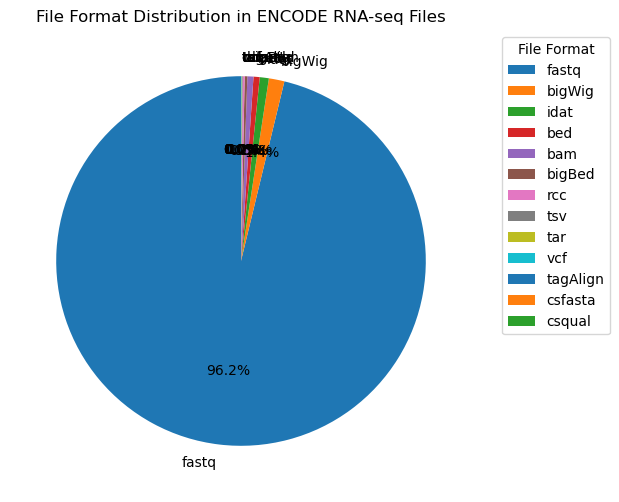

In [ ]:
from matplotlib import pyplot as plt
file_format_counts = interim_files_samples['File Format'].value_counts()
plt.figure(figsize=(8, 6))
file_format_counts.plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('File Format Distribution in ENCODE RNA-seq Files')
plt.ylabel('')
plt.legend(title='File Format', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Download files for each sample

I have looked into various ways to find all files associated with a specific sample, which turns out to be not so straightforward. One main reason is that the replicate.library.biosample field is only provided for some file types (e.g., fastq), unfortunately not for downstream files (e.g., bam) we want to directly use without having to process raw data. I have tried/thought of the following:

1. Get the replicate id of a file in the form of /replicates/NNNN... This however is only available for raw data files. 
2. Get the Library accession(s) associated with each sample (possibly with multiple libraries). But only "raw data" (?) files have library accession (only checked one bam file without library info). Biosample also doesn't have libary info either. 
3. Get the biological replicate number, technical replicate number, and donor info provided for each file, and then use it to track the biosample id. This might still work if first getting the experiment for the file and then find out which sample has the biological replicate and technical replicate number in that experiment. This should be doable as the experiment report gives replicate(s) and biosample(s) information. One issue is that different replicates may have the same Biosample id and the experiment report appears to merge the same IDs, making matching replicate_no-sample_id ambiguous (need to check this further, looks promising. Note that different technical replicates usually have the same Biosample id)

I tried to download the biosample accessions together with replicate numbers (both bio and tech) when querying report.tsv?type=Experiment. However, biosample and replicate accessions returned empty. Experiment report does provide a list of replicate ids. So one way to get the replicates-biosample matchup is to search replicates (e.g., report.tsv?type=Replicate)

4. This is the method implemented by looking at the "Derived form" field of downstream files and HOPING the upstream file(s) has biosmaple id.

### Note on downloading processed files
We may want to also check the file analysis method/pipeline used to be consistent

In [ ]:
# For each biosample_id, get its ENCODE page and save the page into a png image
for group_id in final_groups.groups.keys():
    url = f"https://www.encodeproject.org/{group_id.strip('/')}/"
    save_path = f"data/encode/{group_id.strip('/')}.png"
    print(f"Saving ENCODE page {url} to {save_path} with ")
    !wkhtmltoimage --width 1024 --height 0 {url} {save_path}
    break  # just do one for testing

Saving ENCODE page https://www.encodeproject.org/biosamples/ENCBS001KXB/ to data/encode/biosamples/ENCBS001KXB.png with 
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


In [34]:
# Each biosample as a group and download files for each assay type
assay_file_types = {
    'total RNA-seq': ['fastq',],
    'DNase-seq': ['fastq',],
}

if 'init_files_samples' not in globals():
    init_files_samples = pd.read_pickle("data/encode/init_files_samples.pkl")
    print(f"Loaded ENCODE file biosample data with shape: {init_files_samples.shape}")
init_files_samples.set_index('Accession', inplace=True, drop=False)
init_files_samples.index.name = 'Index'

if 'final_files_samples' not in globals():
    final_files_samples = pd.read_pickle("data/encode/final_files_samples.pkl")
    print(f"Loaded final ENCODE file biosample data with shape: {final_files_samples.shape}")
final_files_samples.set_index('Accession', inplace=True, drop=False)
final_files_samples.index.name = 'Index'


groupby = 'Biosample accession'
groupby = 'Organ'
download_path = Path(f"data/encode/downloads_organ")

final_groups = final_files_samples.groupby(groupby)
files_by_dataset = init_files_samples.groupby('Dataset')

importlib.reload(brew_omics)
download_report = brew_omics.download_encode_files_by_groups(
    init_files_samples, # The master metata is needed to find other files (e.g., bam, bigwig) from the same samples
    groupby, assay_file_types, download_path,
    files_groups=final_groups,
    files_by_dataset=files_by_dataset,
    check_same_sample=(groupby.lower() == 'biosample accession'),
    download_now=False,
)

print(f"Downloaded a total of {len(download_report)} files for selected biosamples and assay types.")
final_files_downloads = pd.merge(init_files_samples, download_report, on='Accession', how='inner')
final_files_downloads.to_pickle("data/encode/final_files_downloads.pkl")
final_files_downloads.to_csv("data/encode/final_files_downloads.csv", index=False)
print("Saved final downloaded files metadata to data/encode/final_files_downloads.pkl/csv")

Organ:   0%|          | 0/37 [00:00<?, ?it/s]

Organ: adrenal gland,endocrine gland; saved metadata to data/encode/downloads_organ/adrenalgland_endocrinegland.csv
    Assay: total RNA-seq, Datasets: []
    Assay: DNase-seq, Datasets: ['/experiments/ENCSR865ICK/', '/experiments/ENCSR191FOV/', '/experiments/ENCSR060BFU/', '/experiments/ENCSR848XIY/', '/experiments/ENCSR856QJX/', '/experiments/ENCSR866RCY/', '/experiments/ENCSR728BAD/', '/experiments/ENCSR696XSJ/', '/experiments/ENCSR419MZH/', '/experiments/ENCSR541JMK/', '/experiments/ENCSR053ZKP/', '/experiments/ENCSR458AOS/', '/experiments/ENCSR277KRY/', '/experiments/ENCSR597NVK/', '/experiments/ENCSR325FWM/', '/experiments/ENCSR598YQI/', '/experiments/ENCSR080PZL/', '/experiments/ENCSR833DYD/', '/experiments/ENCSR259GYP/', '/experiments/ENCSR962VJO/']


Organ:   3%|▎         | 1/37 [00:02<01:36,  2.68s/it]

    Dataset /experiments/ENCSR865ICK/ has 53 files.
    File accession: ENCFF220LZQ
    File accession: ENCFF784CJU
    File accession: ENCFF991YFL
    File accession: ENCFF391QPN
    File accession: ENCFF629RYZ
    File accession: ENCFF036OXC
    File accession: ENCFF504HQG
    File accession: ENCFF466GBQ
    File accession: ENCFF411QZU
    File accession: ENCFF244XPY
    File accession: ENCFF232YBS
    File accession: ENCFF894ELE
    Dataset /experiments/ENCSR191FOV/ has 63 files.
    File accession: ENCFF058NNU
    File accession: ENCFF802HDT
    File accession: ENCFF994JJX
    File accession: ENCFF031MXQ
    File accession: ENCFF195BAO
    File accession: ENCFF963BRG
    File accession: ENCFF508KXW
    File accession: ENCFF552AEK
    File accession: ENCFF417UHG
    File accession: ENCFF268POH
    Dataset /experiments/ENCSR060BFU/ has 61 files.
    File accession: ENCFF627NJR
    File accession: ENCFF972GUR
    File accession: ENCFF953QYX
    Dataset /experiments/ENCSR848XIY/ has 48

Organ:  11%|█         | 4/37 [00:04<00:34,  1.04s/it]

    File accession: ENCFF523XCE
    Dataset /experiments/ENCSR738AGR/ has 8 files.
    File accession: ENCFF598ZWL
    File accession: ENCFF312SMM
    Dataset /experiments/ENCSR485IIT/ has 8 files.
    File accession: ENCFF501ZXG
    File accession: ENCFF362EFZ
    Dataset /experiments/ENCSR805MYY/ has 8 files.
    File accession: ENCFF163YRV
    File accession: ENCFF610LXF
    Dataset /experiments/ENCSR733NLD/ has 8 files.
    File accession: ENCFF290PHQ
    File accession: ENCFF616KJM
    Dataset /experiments/ENCSR660HSO/ has 8 files.
    File accession: ENCFF846TDJ
    File accession: ENCFF412OTC
    Dataset /experiments/ENCSR870YMP/ has 8 files.
    File accession: ENCFF902VNX
    File accession: ENCFF309GAZ
    Dataset /experiments/ENCSR622YET/ has 8 files.
    File accession: ENCFF141QQU
    File accession: ENCFF394TWC
    Dataset /experiments/ENCSR207NON/ has 8 files.
    File accession: ENCFF005CKM
    File accession: ENCFF955DZX
    Dataset /experiments/ENCSR993RWL/ has 8 file

Organ:  19%|█▉        | 7/37 [00:04<00:15,  2.00it/s]

Organ: breast,epithelium; saved metadata to data/encode/downloads_organ/breast_epithelium.csv
    Assay: total RNA-seq, Datasets: []
    Assay: DNase-seq, Datasets: ['/experiments/ENCSR600KUR/', '/experiments/ENCSR859LTL/', '/experiments/ENCSR788IZL/', '/experiments/ENCSR708IUB/']
    Dataset /experiments/ENCSR600KUR/ has 44 files.
    File accession: ENCFF920WVZ
    File accession: ENCFF202YSC
    File accession: ENCFF515PKO
    File accession: ENCFF486BMA
    Dataset /experiments/ENCSR859LTL/ has 38 files.
    File accession: ENCFF076ZYG
    File accession: ENCFF301JFM
    File accession: ENCFF175IOO
    File accession: ENCFF767NOK
    Dataset /experiments/ENCSR788IZL/ has 40 files.
    File accession: ENCFF878MLO
    File accession: ENCFF943OVG
    File accession: ENCFF162KAI
    File accession: ENCFF069QUP
    File accession: ENCFF243LZZ
    File accession: ENCFF546DIU
    Dataset /experiments/ENCSR708IUB/ has 8 files.
    File accession: ENCFF696GYU
    File accession: ENCFF364HRW

Organ:  24%|██▍       | 9/37 [00:04<00:09,  2.85it/s]

    File accession: ENCFF961XOI
    Dataset /experiments/ENCSR628NEA/ has 30 files.
    File accession: ENCFF345ZJI
    File accession: ENCFF705KGJ
    File accession: ENCFF979UTE
    File accession: ENCFF664LAC
    Dataset /experiments/ENCSR608NWP/ has 30 files.
    File accession: ENCFF564HGS
    File accession: ENCFF372EVM
    File accession: ENCFF915XVF
    File accession: ENCFF745YPD
Organ: extraembryonic component; saved metadata to data/encode/downloads_organ/extraembryoniccomponent.csv
    Assay: total RNA-seq, Datasets: []
    Assay: DNase-seq, Datasets: ['/experiments/ENCSR512CWR/', '/experiments/ENCSR000EIL/']
    Dataset /experiments/ENCSR512CWR/ has 112 files.
    File accession: ENCFF519LXB
    File accession: ENCFF120JBD
    File accession: ENCFF002DXA
    File accession: ENCFF002DWY
    File accession: ENCFF002DXB
    File accession: ENCFF002DXC
    File accession: ENCFF002DXD
    File accession: ENCFF002DWZ
    File accession: ENCFF808ALS
    File accession: ENCFF042ZE

Organ:  35%|███▌      | 13/37 [00:05<00:05,  4.28it/s]

Organ: heart; saved metadata to data/encode/downloads_organ/heart.csv
    Assay: total RNA-seq, Datasets: []
    Assay: DNase-seq, Datasets: ['/experiments/ENCSR392GCE/', '/experiments/ENCSR064GBK/', '/experiments/ENCSR501FWC/', '/experiments/ENCSR946DXB/', '/experiments/ENCSR664PKM/', '/experiments/ENCSR749BWV/', '/experiments/ENCSR536NGW/', '/experiments/ENCSR804RSI/', '/experiments/ENCSR705CNJ/', '/experiments/ENCSR533VAF/', '/experiments/ENCSR320PGJ/', '/experiments/ENCSR154ZNQ/', '/experiments/ENCSR189YJQ/', '/experiments/ENCSR085MZL/', '/experiments/ENCSR777DXQ/', '/experiments/ENCSR485UQY/', '/experiments/ENCSR895GSY/', '/experiments/ENCSR374VQC/', '/experiments/ENCSR747SEU/', '/experiments/ENCSR356RNZ/', '/experiments/ENCSR524QBS/', '/experiments/ENCSR032NNU/', '/experiments/ENCSR238FMP/', '/experiments/ENCSR746RDJ/', '/experiments/ENCSR299QGI/', '/experiments/ENCSR211SUT/', '/experiments/ENCSR222CLC/', '/experiments/ENCSR770OTB/', '/experiments/ENCSR928WMU/', '/experiments/ENC

Organ:  41%|████      | 15/37 [00:05<00:04,  4.97it/s]

    Assay: DNase-seq, Datasets: ['/experiments/ENCSR873ANE/', '/experiments/ENCSR792ZXA/', '/experiments/ENCSR774RCO/', '/experiments/ENCSR295DUI/', '/experiments/ENCSR550UWM/', '/experiments/ENCSR155NPL/', '/experiments/ENCSR828RNY/', '/experiments/ENCSR437KLY/', '/experiments/ENCSR106OKX/', '/experiments/ENCSR066WZJ/', '/experiments/ENCSR871APX/', '/experiments/ENCSR765BSU/', '/experiments/ENCSR849OKE/', '/experiments/ENCSR928SYE/', '/experiments/ENCSR851ZFT/', '/experiments/ENCSR979BPU/', '/experiments/ENCSR670ZSA/', '/experiments/ENCSR600RAA/', '/experiments/ENCSR184DFF/', '/experiments/ENCSR619DRM/', '/experiments/ENCSR364TKL/', '/experiments/ENCSR301RCD/', '/experiments/ENCSR543YPH/', '/experiments/ENCSR422PVL/', '/experiments/ENCSR120LVW/', '/experiments/ENCSR022ECC/', '/experiments/ENCSR606UAR/', '/experiments/ENCSR082JCE/', '/experiments/ENCSR332BSB/', '/experiments/ENCSR017TFH/', '/experiments/ENCSR656QYL/', '/experiments/ENCSR911YVV/', '/experiments/ENCSR554WUJ/', '/experime

Organ:  46%|████▌     | 17/37 [00:05<00:03,  5.36it/s]

    File accession: ENCFF862GNE
    File accession: ENCFF759LEG
    File accession: ENCFF121ZPP
    File accession: ENCFF885SVB
    File accession: ENCFF729QBJ
    Dataset /experiments/ENCSR791BHE/ has 40 files.
    File accession: ENCFF978WKQ
    File accession: ENCFF505JHO
    File accession: ENCFF538YZN
    File accession: ENCFF836SRI
    File accession: ENCFF612PHH
    File accession: ENCFF806BGH
    Dataset /experiments/ENCSR166TEE/ has 59 files.
    File accession: ENCFF249RTG
    Dataset /experiments/ENCSR622CAH/ has 60 files.
    File accession: ENCFF173RST
    Dataset /experiments/ENCSR760OPF/ has 8 files.
    File accession: ENCFF726HNS
    File accession: ENCFF349NEG
    Dataset /experiments/ENCSR721NHV/ has 8 files.
    File accession: ENCFF731BZL
    File accession: ENCFF005VEV
    Dataset /experiments/ENCSR856XLJ/ has 40 files.
    File accession: ENCFF772OJE
    File accession: ENCFF263RVL
    File accession: ENCFF530NUT
    File accession: ENCFF659XQU
    File accession

Organ:  57%|█████▋    | 21/37 [00:06<00:02,  7.48it/s]

    File accession: ENCFF120FQU
    File accession: ENCFF416YBE
    Dataset /experiments/ENCSR582IPV/ has 157 files.
    File accession: ENCFF002DWC
    File accession: ENCFF002DWD
    File accession: ENCFF002DVZ
    File accession: ENCFF002DWB
    File accession: ENCFF002DXN
    File accession: ENCFF002DXO
    File accession: ENCFF002DWE
    File accession: ENCFF002DWA
    File accession: ENCFF002DXI
    File accession: ENCFF002DXL
    File accession: ENCFF002DXM
    Dataset /experiments/ENCSR263IGU/ has 61 files.
    File accession: ENCFF746WJD
    File accession: ENCFF352EYU
    File accession: ENCFF922JIL
    Dataset /experiments/ENCSR097KCC/ has 16 files.
    File accession: ENCFF981MEV
    File accession: ENCFF250IEI
    File accession: ENCFF966DJD
    File accession: ENCFF723SDR
    Dataset /experiments/ENCSR934FJL/ has 8 files.
    File accession: ENCFF744WZX
    File accession: ENCFF228EUP
    Dataset /experiments/ENCSR299WPC/ has 16 files.
    File accession: ENCFF896LIN
    

Organ:  68%|██████▊   | 25/37 [00:06<00:01, 11.42it/s]

    File accession: ENCFF229KET
    File accession: ENCFF585FVL
Organ: nerve; saved metadata to data/encode/downloads_organ/nerve.csv
    Assay: total RNA-seq, Datasets: []
    Assay: DNase-seq, Datasets: ['/experiments/ENCSR672MOG/']
    Dataset /experiments/ENCSR672MOG/ has 30 files.
    File accession: ENCFF507GHQ
    File accession: ENCFF066NJJ
    File accession: ENCFF854TBX
    File accession: ENCFF025PXL
Organ: nerve,limb; saved metadata to data/encode/downloads_organ/nerve_limb.csv
    Assay: total RNA-seq, Datasets: []
    Assay: DNase-seq, Datasets: ['/experiments/ENCSR401ESD/', '/experiments/ENCSR484UAU/', '/experiments/ENCSR754WNA/', '/experiments/ENCSR100TUY/', '/experiments/ENCSR508FVM/']
    Dataset /experiments/ENCSR401ESD/ has 52 files.
    File accession: ENCFF190OLW
    File accession: ENCFF898YFD
    File accession: ENCFF318KVK
    File accession: ENCFF203LXQ
    Dataset /experiments/ENCSR484UAU/ has 40 files.
    File accession: ENCFF893JMU
    File accession: ENCF

Organ:  73%|███████▎  | 27/37 [00:06<00:00, 10.69it/s]

    File accession: ENCFF571SMS
    File accession: ENCFF734TMS
    File accession: ENCFF511RWT
    Dataset /experiments/ENCSR426DTX/ has 16 files.
    File accession: ENCFF243PUI
    File accession: ENCFF650WVK
    File accession: ENCFF461GZV
    File accession: ENCFF773ZDL
    Dataset /experiments/ENCSR102GJU/ has 8 files.
    File accession: ENCFF186WPY
    File accession: ENCFF529KRG
    Dataset /experiments/ENCSR000ELL/ has 9 files.
Organ: placenta,extraembryonic component; saved metadata to data/encode/downloads_organ/placenta_extraembryoniccomponent.csv
    Assay: total RNA-seq, Datasets: []
    Assay: DNase-seq, Datasets: ['/experiments/ENCSR552XJI/', '/experiments/ENCSR552RKI/', '/experiments/ENCSR035QHH/', '/experiments/ENCSR167OVP/', '/experiments/ENCSR575VMI/', '/experiments/ENCSR129TSG/', '/experiments/ENCSR499IFY/', '/experiments/ENCSR989YIV/', '/experiments/ENCSR648RAX/', '/experiments/ENCSR802AJE/', '/experiments/ENCSR545KQR/', '/experiments/ENCSR336RGT/', '/experiments

Organ:  84%|████████▍ | 31/37 [00:06<00:00, 14.78it/s]

    File accession: ENCFF260GSJ
    Dataset /experiments/ENCSR794KHT/ has 8 files.
    File accession: ENCFF970PWB
    File accession: ENCFF126KSC
    Dataset /experiments/ENCSR441NLO/ has 8 files.
    File accession: ENCFF139SIK
    File accession: ENCFF165EDS
    Dataset /experiments/ENCSR092LHI/ has 8 files.
    File accession: ENCFF366ZFZ
    File accession: ENCFF598WLG
    Dataset /experiments/ENCSR178XHL/ has 8 files.
    File accession: ENCFF725QWM
    File accession: ENCFF904ZFG
    Dataset /experiments/ENCSR106LXV/ has 8 files.
    File accession: ENCFF312RMC
    File accession: ENCFF818NLL
    Dataset /experiments/ENCSR864BXZ/ has 16 files.
    File accession: ENCFF091BCW
    File accession: ENCFF970MWB
    File accession: ENCFF317YDM
    File accession: ENCFF262UFZ
    Dataset /experiments/ENCSR748RZI/ has 8 files.
    File accession: ENCFF129KLR
    File accession: ENCFF096WKX
    Dataset /experiments/ENCSR134TVI/ has 24 files.
    File accession: ENCFF192MXH
    File acces

Organ: 100%|██████████| 37/37 [00:06<00:00,  5.36it/s]

    File accession: ENCFF848NYW
    File accession: ENCFF716WKO
    File accession: ENCFF359CJV
    File accession: ENCFF033QYM
    File accession: ENCFF655XTX
    File accession: ENCFF373PSV
    File accession: ENCFF790FQW
    Dataset /experiments/ENCSR729DRB/ has 60 files.
    File accession: ENCFF063AKU
    File accession: ENCFF502LJY
    Dataset /experiments/ENCSR978QUT/ has 42 files.
    File accession: ENCFF552IRG
    File accession: ENCFF720UVP
    File accession: ENCFF155ZVD
    File accession: ENCFF707JMV
    Dataset /experiments/ENCSR866ODX/ has 38 files.
    File accession: ENCFF536PRH
    File accession: ENCFF349IJY
    File accession: ENCFF048RXA
    File accession: ENCFF881XDM
Organ: urinary bladder; saved metadata to data/encode/downloads_organ/urinarybladder.csv
    Assay: total RNA-seq, Datasets: []
    Assay: DNase-seq, Datasets: ['/experiments/ENCSR813CKU/']
    Dataset /experiments/ENCSR813CKU/ has 66 files.
    File accession: ENCFF002DZD
    File accession: ENCFF0

Saved final downloaded files metadata to data/encode/final_files_downloads.pkl/csv
